# **Capstone: Using ML on fundamentals to predict South African equities**
---



# **1. Interactive visualisation of PCA: Principal Components and Features**

In [1]:
#Important libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
from itertools import cycle
from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool
import warnings
warnings.filterwarnings(action='ignore')
output_notebook()
%matplotlib inline

# 1a. PCA code

In [2]:

def get_float_list(range_max:int, div:int=100) -> list:
    """ To get 0 -> 1, range_max must be same order of mag as div """
    return [float(x)/div for x in range(int(range_max))]


def get_colorcycle(colordict:dict):
    """ Subset cnames with a string match and get a color cycle for plotting """
    return cycle(list(colordict.keys()))


def get_colordict(filter_:str='dark') -> dict:
    """ return dictionary of colornames by filter """
    return dict((k, v) for k, v in cnames.items() if filter_ in k)


def pca_report_interactive(X, scale_X:bool=True, save_plot:bool=False):
    """
    X:          input data matrix
    scale_X:    determine whether to rescale X (StandardScaler) [default: True, X is not prescaled
    save_plot:  save plot to file (html) and not show
    """

    # calculate mean and var
    X_mean, X_var = X.mean(), X.var()
    print('\n*--- PCA Report ---*\n')
    print(f'X mean:\t\t{X_mean:.3f}\nX variance:\t{X_var:.3f}')

    if scale_X:
        # rescale and run PCA
        print("\n...Rescaling data...\n")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_s_mean, X_s_var = X_scaled.mean(), X_scaled.var()
        print(f'X_scaled mean:\t\t{np.round(X_s_mean):.3f}')
        print(f'X_scaled variance:\t{np.round(X_s_var):.3f}\n')
        pca_ = PCA().fit(X_scaled)
        X_pca = PCA().fit_transform(X_scaled) #I changed "X" to "X_scaled"
    else:
        # run PCA directly
        print("...Assuming data is properly scaled...")
        pca_ = PCA().fit(X)
        X_pca = PCA().fit_transform(X)
            
    # Get cumulative explained variance for each dimension
    pca_evr = pca_.explained_variance_ratio_
    cumsum_ = np.cumsum(pca_evr)
    
    # Get dimensions where var >= 95% and values for variance at 2D, 3D
    dim_95 = np.argmax(cumsum_ >= 0.95) + 1
    twoD = np.round(cumsum_[1], decimals=3)*100 
    threeD = np.round(cumsum_[2], decimals=3)*100
    instances_, dims_ =  X.shape
    
    # check shape of X
    if dims_ > instances_:
        print("WARNING: number of features greater than number of instances.")
        dimensions = list(range(1, instances_+1))
    else:
        dimensions = list(range(1, dims_+1))
    
    # Print report
    print("\n -- Summary --")
    print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")
    print(f"2 principal components explain {twoD:.2f}% of variance.")
    print(f"3 principal components explain {threeD:.2f}% of variance.")
    
    """ - Plotting - """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(names=['PCA'], tooltips=[("dimensions", "@x_dim"), 
                                                ("cumulative variance", "@y_cumvar"),
                                                ("explained variance", "@y_var")])
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'tap', 'box_zoom']

    # insert 0 at beginning for cleaner plotting
    cumsum_plot = np.insert(cumsum_, 0, 0) 
    pca_evr_plot = np.insert(pca_evr, 0, 0)
    dimensions_plot = np.insert(dimensions, 0, 0)

    """
    ColumnDataSource
    - a special type in Bokeh that allows you to store data for plotting
    - store data as dict (key:list)
    - to plot two keys against one another, make sure they're the same length!
    - below:
        x_dim    # of dimensions (length = # of dimensions)
        y_cumvar # cumulative variance (length = # of dimensions)
        var_95   # y = 0.95 (length = # of dimensions)
        zero_one # list of 0 to 1
        twoD     # x = 2 
        threeD   # x = 3 
    """ 
    
    # get sources
    source_PCA = ColumnDataSource(data=dict(x_dim = dimensions_plot,y_cumvar = cumsum_plot, y_var = pca_evr_plot))    
    source_var95 = ColumnDataSource(data=dict(var95_x = [dim_95]*96, var95_y = get_float_list(96)))
    source_twoD = ColumnDataSource(data=dict(twoD_x = [2]*(int(twoD)+1), twoD_y = get_float_list(twoD+1)))
    source_threeD = ColumnDataSource(data=dict(threeD_x = [3]*(int(threeD)+1), threeD_y = get_float_list(threeD+1)))

    """ PLOT """
    # set up figure and add axis labels
    p = figure(title='PCA Analysis', tools=p_tools)
    p.xaxis.axis_label = f'N of {dims_} Principal Components' 
    p.yaxis.axis_label = 'Variance Explained (per PC & Cumulative)'
    
    # add reference lines: y=0.95, x=2, x=3
    p.line('twoD_x', 'twoD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_twoD) # x=2
    p.line('threeD_x', 'threeD_y', line_width=0.5, line_dash='dotted', color='#435363', source=source_threeD) # x=3
    p.line('var95_x', 'var95_y', line_width=2, line_dash='dotted', color='#435363', source=source_var95) # var = 0.95

    # add bar plot for variance per dimension
    p.vbar(x='x_dim', top='y_var', width=.5, bottom=0, color='#D9F2EF', source=source_PCA, name='PCA')
    
    # add cumulative variance (scatter + line)
    p.line('x_dim', 'y_cumvar', line_width=1, color='#F79737', source=source_PCA)
    p.circle('x_dim', 'y_cumvar', size=7, color='#FF4C00', source=source_PCA, name='PCA')

    # change gridlines
    p.ygrid.grid_line_alpha = 0.25
    p.xgrid.grid_line_alpha = 0.25

    # change axis bounds and grid
    p.xaxis.bounds = (0, dims_)
    p.yaxis.bounds = (0, 1)
    p.grid.bounds = (0, dims_)

    # save and show p
    if save_plot:
        output_file('PCA_analysis.html')
    show(p)
        
    # output PCA info as a dataframe
    df_PCA = pd.DataFrame({'dimension': dimensions, 'variance_cumulative': cumsum_, 'variance': pca_evr}).set_index(['dimension'])
        
    return df_PCA, X_pca, pca_evr


def pca_feature_correlation(X, X_pca, explained_var, features:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    1. Get dot product of X and X_pca
    2. Run normalizations of X*X_pca
    3. Retrieve df/matrices

    X:               data (numpy matrix)
    X_pca:           PCA
    explained_var:   explained variance matrix
    features:        list of feature names
    fig_dpi:         dpi to use for heatmaps
    save_plot:       save plot to file (html) and not show
    """
    
    # Add zeroes for data where features > instances
    outer_diff = X.T.shape[0] - X_pca.shape[1]
    if outer_diff > 0: # outer dims must match to get sq matrix
        Z = np.zeros([X_pca.shape[0], outer_diff])
        X_pca = np.c_[X_pca, Z]
        explained_var = np.append(explained_var, np.zeros(outer_diff))
    
    # Get correlation between original features (X) and PCs (X_pca)
    dot_matrix = np.dot(X.T, X_pca)
    print(f"X*X_pca: {X.T.shape} * {X_pca.shape} = {dot_matrix.shape}")
    
    # Correlation matrix -> df
    df_dotproduct = pd.DataFrame(dot_matrix)
    df_dotproduct.columns = [''.join(['PC', f'{i+1}']) for i in range(dot_matrix.shape[0])]
    if any(features): df_dotproduct.index = features    
    
    # Normalize & Sort
    df_n, df_na, df_nabv = normalize_dataframe(df_dotproduct, explained_var, plot_opt=True, save_plot=save_plot)
    
    return df_dotproduct, df_n, df_na, df_nabv


def normalize_dataframe(df, explained_var=None, fig_dpi:int=150, plot_opt:bool=True, save_plot:bool=False):
    """
    1. Get z-normalized df (normalized to µ=0, σ=1)
    2. Get absolute value of z-normalized df
    3. If explained_variance matrix provided, dot it w/ (2)
    """
    # Normalize, Reindex, & Sort
    df_norm = (df.copy()-df.mean())/df.std()
    df_norm = df_norm.sort_values(list(df_norm.columns), ascending=False)
    
    # Absolute value of normalized (& sort)
    df_abs = df_norm.copy().abs().set_index(df_norm.index)
    df_abs = df_abs.sort_values(by=list(df_abs.columns), ascending=False)
    
    # Plot
    if plot_opt:
        # Z-normalized corr matrix
        plt.figure(dpi=fig_dpi)
        ax_normal = sns.heatmap(df_norm, cmap="RdBu")
        ax_normal.set_title("Z-Normalized Data")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix.png')
        else:
            plt.show()

        # |Z-normalized corr matrix|  
        plt.figure(dpi=fig_dpi)
        ax_abs = sns.heatmap(df_abs, cmap="Purples")
        ax_abs.set_title("|Z-Normalized|")
        if save_plot:
            plt.savefig('Z_normalized_corr_matrix_Abs.png')
        else:
            plt.show()
        
    # Re-normalize by explained var (& sort)
    if explained_var.any():
        df_byvar = df_abs.copy()*explained_var
        df_byvar = df_byvar.sort_values(by=list(df_norm.columns), ascending=False)
        if plot_opt:
            plt.figure(dpi=fig_dpi)
            ax_relative = sns.heatmap(df_byvar, cmap="Purples")
            ax_relative.set_title("|Z-Normalized|*Explained_Variance")
            if save_plot:
                plt.savefig('Normalized_corr_matrix.png')
            else:
                plt.show()
    else:
        df_byvar = None
    return df_norm, df_abs, df_byvar


def pca_rank_features(df_nabv, verbose:bool=True):
    """
    Given a dataframe df_nabv with dimensions [f, p], where:
        f = features (sorted)
        p = principal components
        df_nabv.values are |Z-normalized X|*pca_.explained_variance_ratio_
        
    1. Create column of sum of each row, sort by it 'score_'
    3. Set index as 'rank'
    """
    df_rank = df_nabv.copy().assign(score_ = df_nabv.sum(axis=1)).sort_values('score_', ascending=False)
    df_rank['feature_'] = df_rank.index
    df_rank.index = range(1, len(df_rank)+1)
    df_rank.drop(df_nabv.columns, axis=1, inplace=True)
    df_rank.index.rename('rank', inplace=True)
    if verbose: print(df_rank)
    return df_rank


def pca_full_report(X, features_:list=None, fig_dpi:int=150, save_plot:bool=False):
    """
    Run complete PCA workflow:
        1. pca_report_interactive()
        2. pca_feature_correlation()
        3. pca_rank_features()
        
    X:            data (numpy array)
    features_:    list of feature names
    fig_dpi:      image resolution
    
    """
    # Retrieve the interactive report
    df_pca, X_pca, pca_evr = pca_report_interactive(X, save_plot=save_plot)
    # Get feature-PC correlation matrices
    df_corr, df_n, df_na, df_nabv = pca_feature_correlation(X, X_pca, pca_evr, features_, fig_dpi, save_plot) 
    # Get rank for each feature
    df_rank = pca_rank_features(df_nabv)
    return (df_pca, X_pca, pca_evr, df_corr, df_n, df_na, df_nabv, df_rank)

# 1b. Running the PCA code on our dataset

## 1b.i. Dataset

In [3]:
""" SA JSE listed companies """
#uploading dataset
from google.colab import files
uploaded = files.upload()

Saving capstone_dataset_python.xlsx to capstone_dataset_python.xlsx


In [5]:
#dataset
dataset = pd.read_excel('capstone_dataset_python.xlsx')
x = dataset.iloc[:,:23] #features: are various annual financial metrics for JSE-listed companies 2010-2019
y1 = dataset.iloc[:,23] #1st target based on mean log share price returns
y2 = dataset.iloc[:,24] #2nd target based on Coefficient of variation of mean log share price returns
y3 = dataset.iloc[:,25] #3rd target based on Standard deviation of mean log share price returns
features = x 
target_1 = y1
target_2 = y2
target_3 = y3
target_name_y1 = pd.DataFrame(y1, columns = ['y1'])
target_name_y2 = pd.DataFrame(y2, columns = ['y2'])
target_name_y3 = pd.DataFrame(y3, columns = ['y3'])

#Convert to numpy array
data = x.to_numpy()
feature_names = x.columns.values

## 1b.ii. Output


*--- PCA Report ---*

X mean:		0.121
X variance:	0.175

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 23 to 15 dimensions while retaining 95% of variance.
2 principal components explain 36.00% of variance.
3 principal components explain 45.60% of variance.


X*X_pca: (23, 85) * (85, 23) = (23, 23)


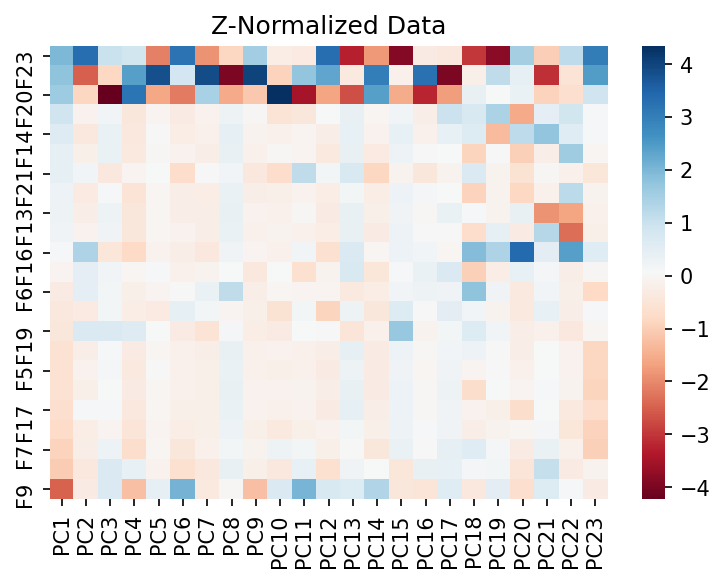

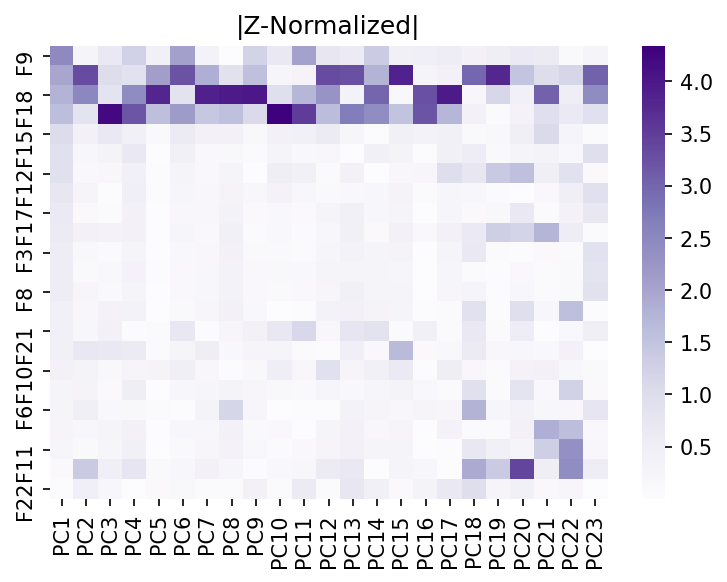

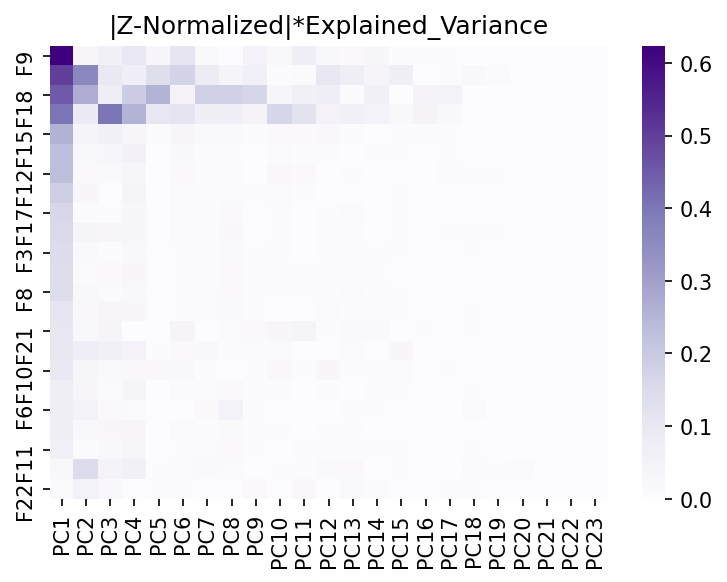

        score_ feature_
rank                   
1     2.182950      F18
2     2.118560      F20
3     1.892622      F23
4     1.223728       F9
5     0.564299      F15
6     0.434358      F19
7     0.433909       F7
8     0.424401      F16
9     0.418802      F12
10    0.369008      F21
11    0.366706      F14
12    0.355239       F4
13    0.329520      F10
14    0.304869      F17
15    0.292265       F8
16    0.287905       F5
17    0.285131       F3
18    0.283598       F1
19    0.282366       F6
20    0.257437       F2
21    0.239220      F13
22    0.222381      F11
23    0.207198      F22


In [6]:
#output
sa_outputs = pca_full_report(X=data, features_=feature_names)

---



# **2a. Prediction**

In [7]:
#important libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from bokeh.plotting import output_notebook, figure, show
from bokeh.models import ColumnDataSource
from matplotlib import colors as mcolors

In [8]:
# create new dataframe by merging x and y1
data_all = features.copy() # copy first to avoid collisions
data_all = data_all.assign(target = target_1) # assign target as new col

# Print one of the dataframes
with pd.option_context('display.max_rows', 3, 'display.max_columns', 2):
    print("\n features and target_1:\n___\n", data_all) #data_all=data_all


 features and target_1:
___
           F1  ...  target
0   0.029883  ...       1
..       ...  ...     ...
84 -0.010862  ...       0

[85 rows x 24 columns]


In [9]:
# Investment call descriptions instead of values
data_target_str = target_1.copy().replace([0,1,2], ['sell','hold+','buy']) 

In [10]:
# 15D PCA dataframe
X_pca2D = PCA(n_components=15).fit_transform(StandardScaler().fit_transform(data))
data_PCA2D = pd.DataFrame(X_pca2D, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                                              'PC11','PC12','PC13','PC14','PC15'])
data_PCA2D = data_PCA2D.assign(target=target_1)
data_PCA2D = data_PCA2D.assign(label=data_target_str)
print("Data 2D PCA:\n___\n", data_PCA2D)

Data 2D PCA:
___
          PC1       PC2       PC3       PC4  ...      PC14      PC15  target  label
0  -1.775194  1.549764 -0.904043  0.753826  ... -0.475114 -0.141484       1  hold+
1   2.272891 -0.866656 -0.572006 -0.196539  ... -0.472393  0.657627       1  hold+
2   0.352222  2.589767  2.194589  7.522526  ...  1.321757  2.130683       1  hold+
3   0.834263 -0.568591 -0.337933 -0.227699  ...  0.766355  0.957971       1  hold+
4   9.140013 -1.471407  1.088699 -0.393984  ...  1.154310  0.720444       1  hold+
..       ...       ...       ...       ...  ...       ...       ...     ...    ...
80 -2.227255 -1.225791  0.677800 -0.723266  ...  0.256147  0.600630       0   sell
81 -3.171438 -0.240184  3.081646 -0.947396  ...  0.425851  0.375882       0   sell
82 -2.775964 -0.058821  3.224339  1.312958  ...  0.102907  0.102488       0   sell
83 -5.787011 -1.269212  0.699552 -1.690286  ... -1.727393  0.408156       0   sell
84 -6.448297 -1.214049  1.461477 -3.331006  ...  2.055408 -0.464007  

# 2b.Predictions generated by classifiers

We examine training and test data, along with predictions, of several classifiers including: K-Nearest Neighbors, and Logistic Regression

In [15]:
# Set seed
np.random.seed(312)
# For this exercise, we'll train using the PCA data (data_PCA2D) - train/test split of 0.7, 0.3
# X_train, X_test, y_train, y_test = train_test_split(X_pca2D, data_y.ravel(), test_size=0.3)
X_train, X_test, y_train, y_test = train_test_split(data_PCA2D[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9',
                                                                'PC10','PC11','PC12','PC13','PC14','PC15']], data_PCA2D['target'], test_size=0.3)

# Select classifier & train
k_neighbors = 2
knn_data = KNeighborsClassifier(n_neighbors=2)
knn_data.fit(X_train, y_train) 

# Return predictions on withheld test data and score
# -- note: knn also has the predict_proba method 
#          will let you know probability for each target
knn_predictions = knn_data.predict(X_test)
print(f"{k_neighbors}NN model accuracy: {knn_data.score(X_test, y_test)}")

2NN model accuracy: 0.8076923076923077


In [16]:
#Feature importance: knn=2
#permutation importance
from sklearn.inspection import permutation_importance
results_kn = permutation_importance(knn_data, X_train, y_train, scoring='accuracy')
#feature importance
feature_importance_kn = results_kn.importances_mean
feature_importance_kn

array([ 0.1559322 ,  0.05762712,  0.04745763,  0.04745763,  0.02711864,
        0.01694915,  0.01355932,  0.01016949, -0.00338983,  0.02711864,
        0.        ,  0.03050847,  0.01694915,  0.02033898,  0.02033898])

In [17]:
# Add predictions column
data_PCA2D = data_PCA2D.assign(predictions=knn_data.predict(data_PCA2D[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9',
                                                                        'PC10','PC11','PC12','PC13','PC14','PC15']]))
colormap_int_label = {'0': 'sell', '1': 'hold+', '2': 'buy'}
predictions_label = [colormap_int_label[str(x)] for x in data_PCA2D.predictions]
data_PCA2D = data_PCA2D.assign(predictions_label=predictions_label)
data_PCA2D

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,target,label,predictions,predictions_label
0,-1.775194,1.549764,-0.904043,0.753826,0.156649,-0.170292,2.191793,2.017256,-1.443146,-0.058309,-1.163446,1.864849,-0.651102,-0.475114,-0.141484,1,hold+,1,hold+
1,2.272891,-0.866656,-0.572006,-0.196539,0.062675,-0.505367,-0.500531,-0.454368,-0.546333,0.221729,0.918264,-0.159582,0.065678,-0.472393,0.657627,1,hold+,1,hold+
2,0.352222,2.589767,2.194589,7.522526,-0.195186,0.791548,-3.141350,0.399168,-0.526975,-2.363877,0.815727,0.616895,-1.804124,1.321757,2.130683,1,hold+,1,hold+
3,0.834263,-0.568591,-0.337933,-0.227699,-1.400978,0.205039,0.437614,-0.894968,-1.007867,0.558966,-1.430438,0.031895,-0.824449,0.766355,0.957971,1,hold+,0,sell
4,9.140013,-1.471407,1.088699,-0.393984,0.546276,-0.388845,0.101617,2.623885,-0.294218,1.333678,1.464437,-0.711182,0.676457,1.154310,0.720444,1,hold+,1,hold+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,-2.227255,-1.225791,0.677800,-0.723266,0.007467,-0.346109,0.821548,0.057055,-0.389535,-0.165105,-1.313224,-0.793592,-0.224168,0.256147,0.600630,0,sell,0,sell
81,-3.171438,-0.240184,3.081646,-0.947396,-1.041581,-0.535858,-0.063295,0.482470,1.362666,1.625390,-0.764141,0.801659,-0.192610,0.425851,0.375882,0,sell,0,sell
82,-2.775964,-0.058821,3.224339,1.312958,0.990578,-0.715605,-1.275879,-0.037307,0.498456,0.803985,-0.215413,-0.637113,-0.592673,0.102907,0.102488,0,sell,0,sell
83,-5.787011,-1.269212,0.699552,-1.690286,1.645884,0.187900,-1.561891,0.046609,0.783421,-1.081808,0.554548,-0.192872,-0.589601,-1.727393,0.408156,0,sell,0,sell


### 2d.i.i Forecasting with KNeighbour algo where K=3, K=11

In [18]:
#Using the function with knn=3 instead of 2
# data
data_colormap = {'0': 'red', '1': 'green', '2': 'orange'} 
data_labelmap = {'0': 'sell', '1': 'hold+', '2': 'buy'} 
X = data
data_targets = target_1
data_labels = [data_labelmap[str(x)] for x in data_targets]

# select classifier & train
neighbors_ = 3
knn_rerun = KNeighborsClassifier(n_neighbors=neighbors_)
knn_rerun.fit(X_train, y_train)
knn_rerun_accuracy = knn_rerun.score(X_test, y_test)
knn_rerun_accuracy

0.8846153846153846

In [19]:
#Feature importance
#permutation importance
from sklearn.inspection import permutation_importance
results_kn = permutation_importance(knn_rerun, X_train, y_train, scoring='accuracy')
#feature importance
feature_importance_kn = results_kn.importances_mean
feature_importance_kn

array([ 0.1559322 ,  0.04067797,  0.01016949,  0.02711864,  0.02372881,
        0.01016949,  0.01694915, -0.02711864,  0.        ,  0.02033898,
        0.02711864,  0.0440678 ,  0.01016949,  0.02033898,  0.02372881])

In [25]:
#Using the function with knn=11
np.random.seed(1002)
# data
data_colormap = {'0': 'red', '1': 'green', '2': 'orange'} 
data_labelmap = {'0': 'sell', '1': 'hold+', '2': 'buy'} 
X = data
data_targets = target_1
data_labels = [data_labelmap[str(x)] for x in data_targets]

# select classifier & train
neighbors_ = 11 #sweet spot 10-15
knn_rerun = KNeighborsClassifier(n_neighbors=neighbors_)
knn_rerun.fit(X_train, y_train)
knn_rerun_accuracy = knn_rerun.score(X_test, y_test)
knn_rerun_accuracy

0.8076923076923077

### 2d.i.ii Forecasting with the SVC algorithm

In [26]:
# New classifier SVC: select classifier & train
#np.random.seed(113)
model_svc = SVC(kernel='linear', C=0.1)
model_svc.fit(X_train, y_train)
model_accuracy = model_svc.score(X_test, y_test)
model_accuracy

0.8461538461538461

2d.i.ii.i Forecasting with the SVC algorithm without dimensionality reduction

In [27]:
# Investment call descriptions instead of values
data_target_str = target_1.copy().replace([0,1,2], ['sell','hold+','buy']) 

# 23D PCA dataframe
X_pca23D = StandardScaler().fit_transform(data)
data_PCA23D = pd.DataFrame(X_pca23D, columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                                              'PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19',
                                              'PC20','PC21','PC22','PC23'])
data_PCA23D = data_PCA23D.assign(target=target_1)#concatenate target column, y1 in this case
data_PCA23D = data_PCA23D.assign(label=data_target_str)
print("Data 2D PCA:\n___\n", data_PCA23D)

Data 2D PCA:
___
          PC1       PC2       PC3       PC4  ...      PC22      PC23  target  label
0  -1.144760 -0.621833 -0.101265  1.079046  ...  1.597656 -0.299096       1  hold+
1   1.052146  1.298139  0.850804  0.271398  ...  0.226466 -0.492625       1  hold+
2  -0.013613 -0.898092  0.580060 -1.535558  ...  0.216837  2.193838       1  hold+
3   0.376791  1.169325 -0.111069  1.321791  ...  0.708886  0.061881       1  hold+
4   4.287152  3.482195  1.094251 -2.035953  ...  0.107065 -1.236544       1  hold+
..       ...       ...       ...       ...  ...       ...       ...     ...    ...
80 -0.906616 -0.676797 -1.358058  0.534144  ... -0.767261 -1.500947       0   sell
81 -0.857300 -1.372603 -1.415118 -0.768498  ... -0.949252  0.473709       0   sell
82 -0.244039 -1.236255 -1.462492 -1.688631  ... -0.681562 -0.195344       0   sell
83 -1.925174 -1.346056 -0.006485  1.292616  ... -1.442264 -0.554887       0   sell
84 -1.690638 -1.482978 -0.613272  0.612046  ... -1.644476 -0.855519  

In [28]:
X2_train, X2_test, y2_train, y2_test = train_test_split(data_PCA23D[['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9',
                                                                'PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17',
                                                                'PC18','PC19','PC20','PC21','PC22','PC23']], 
                                                    data_PCA23D['target'], test_size=0.3)

In [29]:
# SVM classifer by-passing PCA components
#np.random.seed(111)
model_svc2 = SVC(kernel='linear', C=0.1)
model_svc2.fit(X2_train, y2_train)
model_accuracy_svc2 = model_svc2.score(X2_test, y2_test)
model_accuracy_svc2

0.9230769230769231

### 2d.i.iii Forecasting with the Logistic Regression algorithm

In [30]:
# Another classifier: Logistic Regression
#np.random.seed(42)
model_lr = LogisticRegression(penalty='l2', C=50, solver='newton-cg', multi_class='multinomial')
model_lr.fit(X_train, y_train)
model_accuracy = model_lr.score(X_test, y_test)
print(f"Logistic Regression with {100*model_accuracy:.2f}% Accuracy")

Logistic Regression with 80.77% Accuracy


### 2d.i.iv Forecasting with the Decision Tree algorithm

In [31]:
#Now with a Decision Tree classifier
# select classifier & train
model_dt = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)
model_dt.fit(X_train, y_train)
model_accuracy = model_dt.score(X_test, y_test)
print(f"Decision Tree with {100*model_accuracy:.2f}% Accuracy")

Decision Tree with 80.77% Accuracy


In [32]:
#importance of features: Decision Tree
feature_importance=model_dt.feature_importances_
feature_importance

array([0.53970984, 0.        , 0.        , 0.1589261 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.18394134,
       0.        , 0.        , 0.06907219, 0.04835053, 0.        ])

### 2d.i.v Forecasting with the Random Forest algorithm

In [35]:
# Another classifier with a different seed: Random Forest
np.random.seed(218)
model_rf = RandomForestClassifier(n_estimators=8, criterion='entropy', n_jobs=-1)
model_rf.fit(X_train, y_train)
model_accuracy = model_rf.score(X_test, y_test)
print(f"Random Forest with {100*model_accuracy:.2f}% Accuracy")

Random Forest with 88.46% Accuracy


### 2d.i.v Forecasting with the MLP Classifier (neural network) algorithm

In [36]:
# try with a new classifer
mlp_sw = MLPClassifier(activation='relu', hidden_layer_sizes=(23,23), max_iter=500)
mlp_sw.fit(X_train, y_train)
mlp_sw_accuracy = mlp_sw.score(X_test, y_test)
mlp_predictions = mlp_sw.predict(X_test)
print(f"MLP with {100*mlp_sw_accuracy:.2f}% Accuracy")

MLP with 84.62% Accuracy


2d.i.v.i Forecasting with the MLP Classifier (neural network) algorithm by-passing PCA componets as inputs

In [37]:
# MPL classifer by-passing PCA components
#np.random.seed(110)
mlp_sw2 = MLPClassifier(activation='relu', hidden_layer_sizes=(23,23), max_iter=500)
mlp_sw2.fit(X2_train, y2_train)
mlp_sw_accuracy2 = mlp_sw2.score(X2_test, y2_test)
mlp_predictions2 = mlp_sw2.predict(X2_test)
print(f"MLP with {100*mlp_sw_accuracy2:.2f}% Accuracy")

MLP with 96.15% Accuracy


---



# **3. Model performance**: ROC, AUC, confusion matrix & classification report

We will use the MLPClassifier (aka neural networks) algo, without dimensionality reduction,  as our base case given that it has the highest accuracy among peer algos

In [38]:
from itertools import cycle
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, confusion_matrix
from matplotlib.colors import cnames
cnames = dict((k, v) for k, v in cnames.items() if 'dark' in k) # get only dark colors

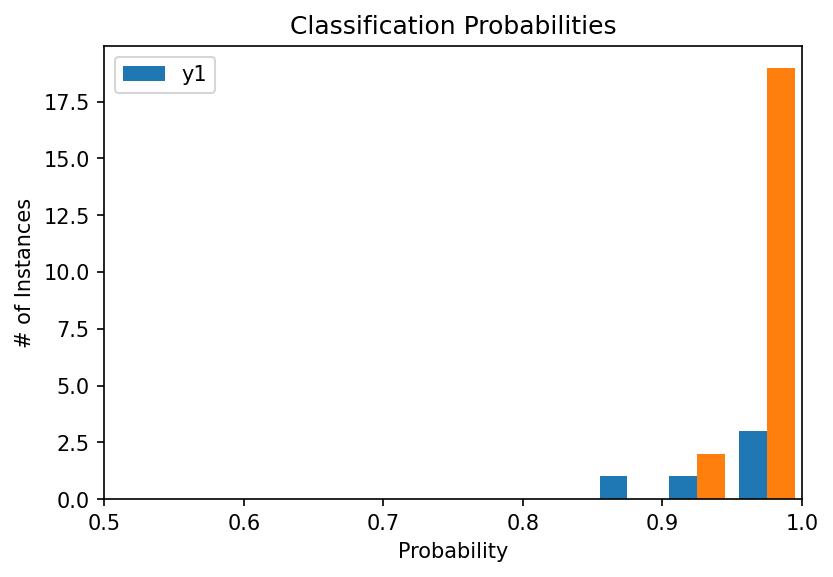

In [40]:
#get probability distribution of MLPClassifier (exPCA)
probas = mlp_sw2.predict_proba(X2_test)

# plot
plt.figure(dpi=150)
plt.hist(probas, bins=20)
plt.title('Classification Probabilities')
plt.xlabel('Probability')
plt.ylabel('# of Instances')
plt.xlim([0.5, 1.0])
plt.legend(target_name_y1)
plt.show()

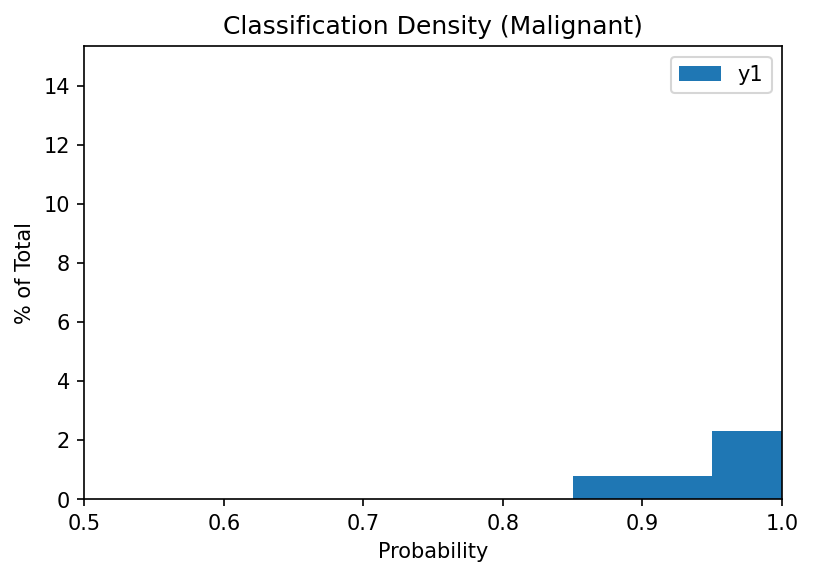

In [41]:
# plot with density instead of counts
plt.figure(dpi=150)
plt.hist(probas[:,0], density=True, bins=20)
plt.title('Classification Density (Malignant)')
plt.xlabel('Probability')
plt.ylabel('% of Total')
plt.xlim([0.5, 1.0])
plt.legend(target_name_y1)
plt.show()

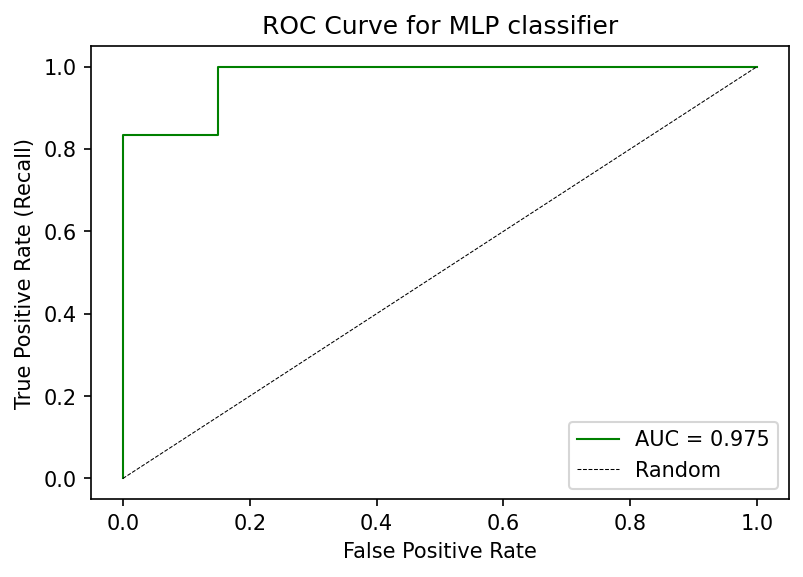

In [42]:
""" ROC curve """

# get false and true positive rates
fpr, tpr, _ = roc_curve(y2_test, probas[:,0], pos_label=0)

# get area under the curve
roc_auc = auc(fpr, tpr)

# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
plt.title('ROC Curve for MLP classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

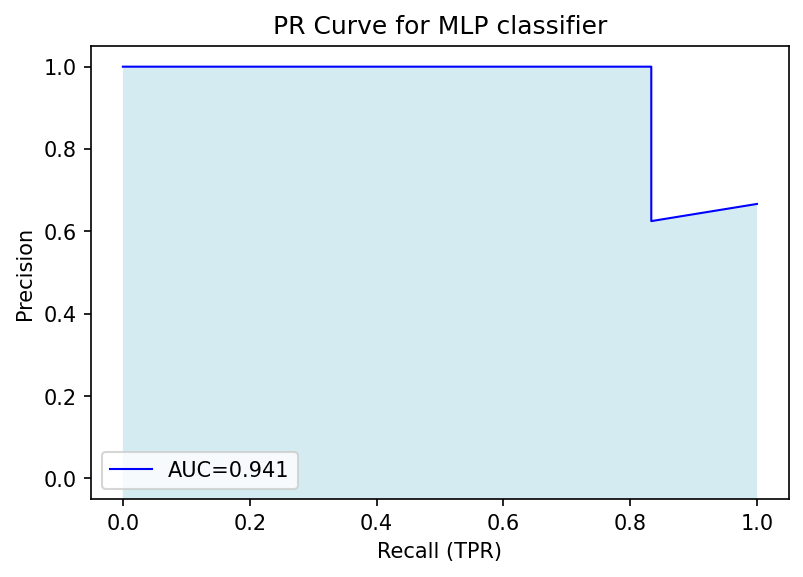

In [43]:
""" Precision Recall Curve """

# get precision and recall values
precision, recall, _ = precision_recall_curve(y2_test, probas[:,0], pos_label=0)

# average precision score
#avg_precision = average_precision_score(y_test, probas[:,1]) #not supported

# precision auc
pr_auc = auc(recall, precision)

# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AUC={pr_auc:.3f}')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)

plt.title('PR Curve for MLP classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

Confusion Matrix

In [46]:
print('confusion matrix', confusion_matrix(y2_test, mlp_predictions2))

confusion matrix [[ 5  1]
 [ 0 20]]


Classification report

In [47]:
print('classification report', classification_report(y2_test, mlp_predictions2))

classification report               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.95      1.00      0.98        20

    accuracy                           0.96        26
   macro avg       0.98      0.92      0.94        26
weighted avg       0.96      0.96      0.96        26



We now put together a general function that can easily produce all performance graphs

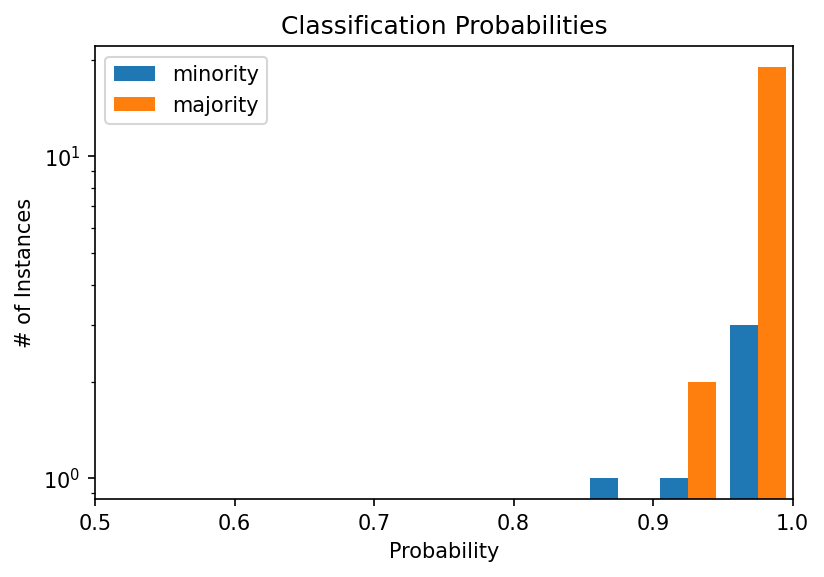

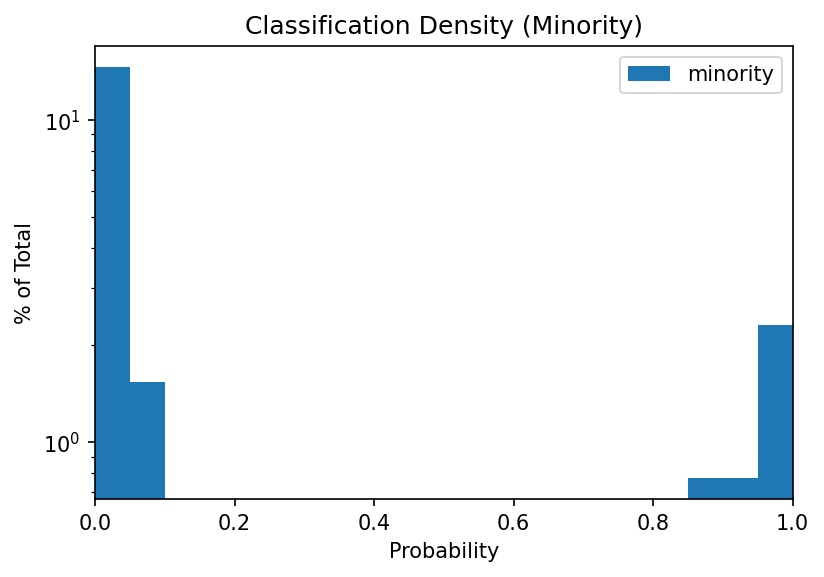

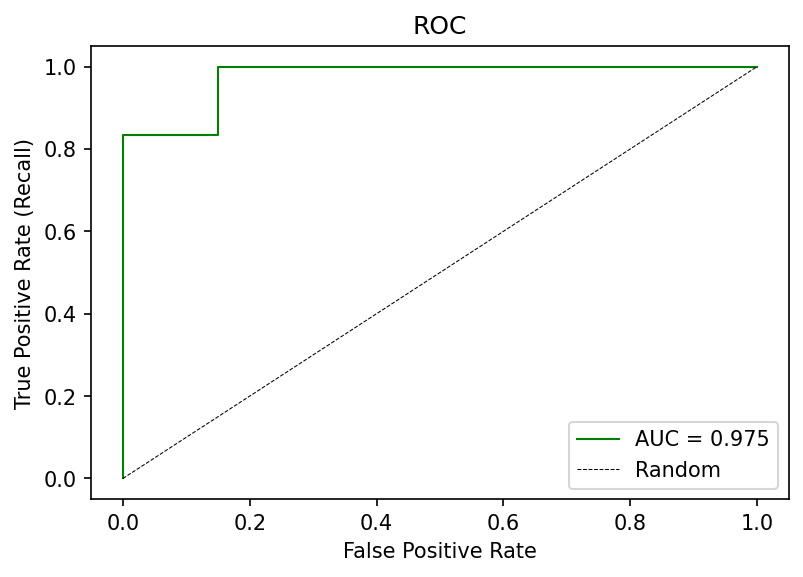

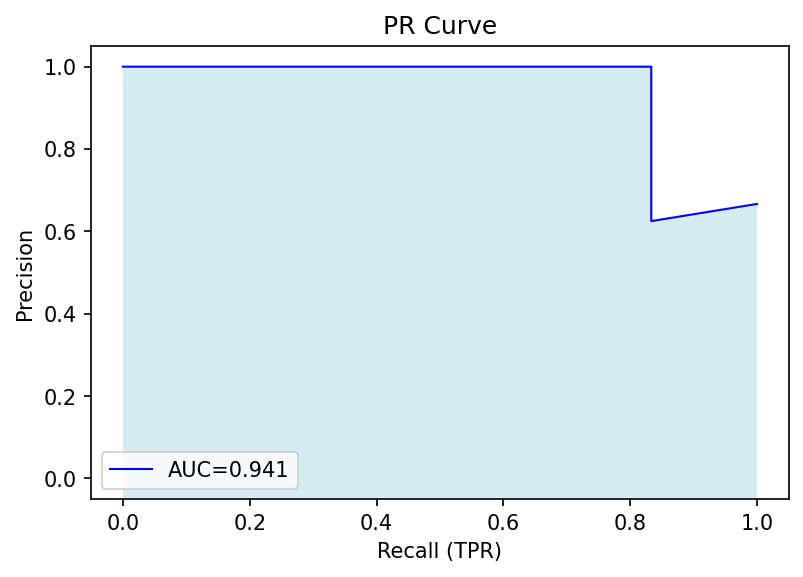

In [48]:
""" Function to return all perfomance plots of a classifer """

def classifier_plots(clf_trained, X2_test, y2_test, target_names:list, minority_idx:int=0, ylog:bool=False):
    """
    Get summary plots for a trained classifier
    
    Args:
        probas: trained sklearn clf
        X_test (np.ndarray): withheld test data
        y_test (np.ndarray): withheld test data labels
        target_names (list): list of target labels/names
        minority_idx: (int): index for the minority class (e.g. 0, 1) 
        ylog (str): toggle log-scaling on yaxis
        
    Returns:
        None
    """
    
    """ Probabilty Dist """
    # get the probability distribution
    probas = mlp_sw2.predict_proba(X2_test)

    # PLOT - count
    plt.figure(dpi=150)
    plt.hist(probas, bins=20)
    plt.title('Classification Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('# of Instances')
    plt.xlim([0.5, 1.0])
    if ylog: plt.yscale('log')
    plt.legend(target_names)
    plt.show()
    
    
    # PLOT - density
    plt.figure(dpi=150)
    plt.hist(probas[:, minority_idx], bins=20, density=True)
    plt.title('Classification Density (Minority)')
    plt.xlabel('Probability')
    plt.ylabel('% of Total')
    if ylog: plt.yscale('log')
    plt.xlim([0, 1.0])
    plt.legend(target_names)
    plt.show()
    
    """ ROC curve """

    # get false and true positive rates
    fpr, tpr, _ = roc_curve(y2_test, probas[:,0], pos_label=0)

    # get area under the curve
    clf_auc = auc(fpr, tpr)

    # PLOT ROC curve
    plt.figure(dpi=150)
    plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {clf_auc:.3f}')
    plt.plot([0,1], [0,1], '--k', lw=0.5, label='Random')
    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.show()
    
    """ Precision Recall Curve """

    # get precision and recall values
    precision, recall, _ = precision_recall_curve(y2_test, probas[:,0], pos_label=0)

    # average precision score
    #avg_precision = average_precision_score(y_test, probas[:,0]) #not supported by colab

    # precision auc
    pr_auc = auc(recall, precision)

    # plot
    plt.figure(dpi=150)
    plt.plot(recall, precision, lw=1, color='blue', label=f'AUC={pr_auc:.3f}')
    plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)

    plt.title('PR Curve')
    plt.xlabel('Recall (TPR)')
    plt.ylabel('Precision')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.show()
    

""" get all plots """
classifier_plots(mlp_sw2, X2_test, y2_test, ['minority', 'majority'], ylog=True)
